## Import necessary libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

## Load the dataset

In [2]:
bigmart_data = pd.read_csv('bigmartsales.csv')
bigmart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Profit
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8,OUT049,1999,Medium,Tier 2,Supermarket Type1,3735.1380,11.5
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.3,OUT018,2009,Medium,Tier 2,Supermarket Type2,443.4228,14.3
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6,OUT049,1999,Medium,Tier 2,Supermarket Type1,2097.2700,14.5
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.1,OUT010,1998,NaN,NaN,Grocery Store,732.3800,13.6
4,NCD19,8.93,Low Fat,0.000000,Household,53.9,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,14.1


## 1(a) Exploratory Data Analysis

First, we'll start with a general overview of the dataset.

In [3]:

bigmart_data.describe(include='all')


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Profit
count,8523,7774.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,6473,8523,8523.000000,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,8,4,NaN,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 2,Supermarket Type1,NaN,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,2793,5577,NaN,NaN
mean,NaN,11.676740,NaN,0.066132,NaN,140.998838,NaN,1997.831867,NaN,NaN,NaN,2181.288914,13.414514
std,NaN,5.776851,NaN,0.051598,NaN,62.258099,NaN,8.371760,NaN,NaN,NaN,1706.499616,1.701840
min,NaN,0.000000,NaN,0.000000,NaN,31.300000,NaN,1985.000000,NaN,NaN,NaN,33.290000,0.100000
25%,NaN,7.720000,NaN,0.026989,NaN,93.800000,NaN,1987.000000,NaN,NaN,NaN,834.247400,13.150000
50%,NaN,11.800000,NaN,0.053931,NaN,142.700000,NaN,1999.000000,NaN,NaN,NaN,1794.331000,13.900000
75%,NaN,16.500000,NaN,0.094585,NaN,185.650000,NaN,2004.000000,NaN,NaN,NaN,3101.296400,14.300000


### Here are the descriptive statistics for the BigMart dataset:

**Item_Identifier:** There are 1,559 unique item identifiers, with the most frequent one being "FDW13".

**Item_Weight:** The weights of items range from 0 to 21.35, with an average weight of approximately 11.68.

**Item_Fat_Content:** This categorical feature has 5 unique values, with "Low Fat" being the most frequent.

**Item_Visibility:** The average visibility is 0.066, and it ranges from 0 to 0.328.

**Item_Type:** There are 16 unique item types, with "Fruits and Vegetables" being the most frequent.

**Item_MRP:** The maximum retail price (MRP) of items ranges from 31.30 to 266.90, with an average of about 141.

**Outlet_Identifier:** There are 10 unique outlets, with "OUT027" being the most frequent.

**Outlet_Establishment_Year:** The outlets were established between 1985 and 2009.

**Outlet_Size:** This categorical feature has 3 unique sizes, with "Medium" being the most frequent. However, there are missing values in this column.

**Outlet_Location_Type:** There seems to be a discrepancy as there are 8 unique location types, which might be due to inconsistent labeling.

**Outlet_Type:** There are 4 unique outlet types, with "Supermarket Type1" being the most frequent.

**Item_Outlet_Sales:** The sales range from 33.29 to 13,086.96, with an average of about 2,181.29.

**Profit:** The profit percentage ranges from 0.1% to 24%, with an average of around 13.41%.

Next, let's visualize the distribution of numerical and categorical features.

### EDA of numerical features

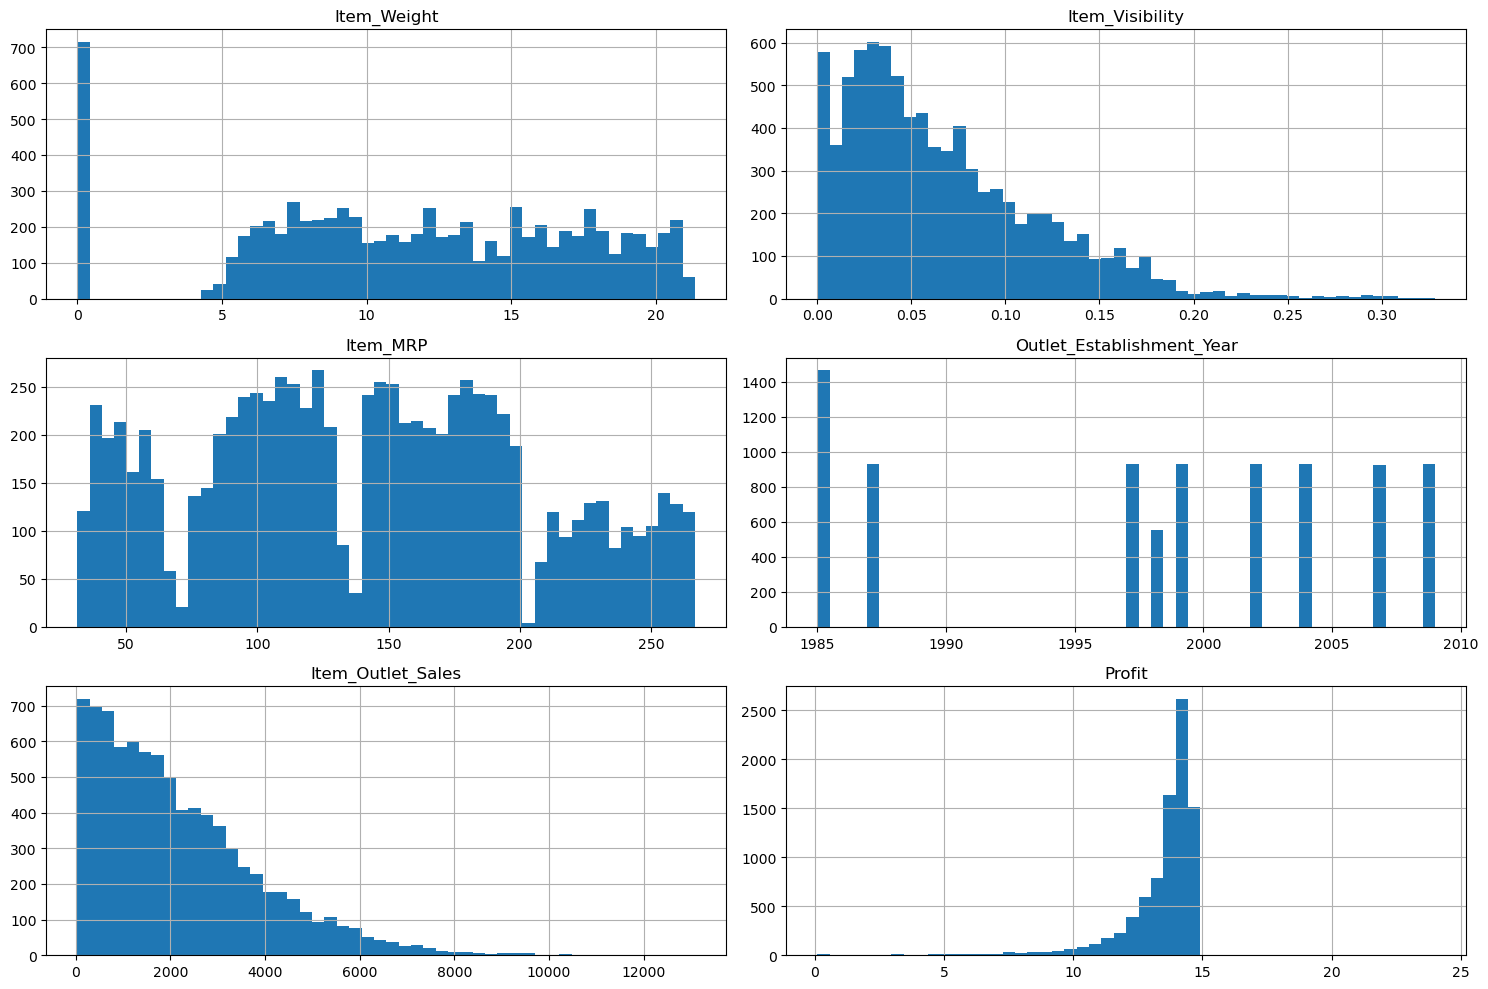

In [4]:

numeric_features = bigmart_data.select_dtypes(include=[np.number])

# Histogram for all numeric features
numeric_features.hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()


The histograms above show the distribution of the numerical features in the dataset. Here's a brief summary:

**Item_MRP:** The maximum retail price seems to have multiple peaks, indicating different pricing categories or clusters.
    
**Item_Outlet_Sales:** The sales distribution is right-skewed, with a majority of items having lower sales.
    
**Item_Visibility:** It's also right-skewed, indicating that many items have low visibility in the store.
    
**Item_Weight:** Appears somewhat uniformly distributed, with slight variations.
    
**Outlet_Establishment_Year:** The distribution shows peaks corresponding to specific years, indicating when most outlets were established.
    
**Profit:** The profit percentage appears left-skewed with most items having a profit percentage between 10% and 20%.

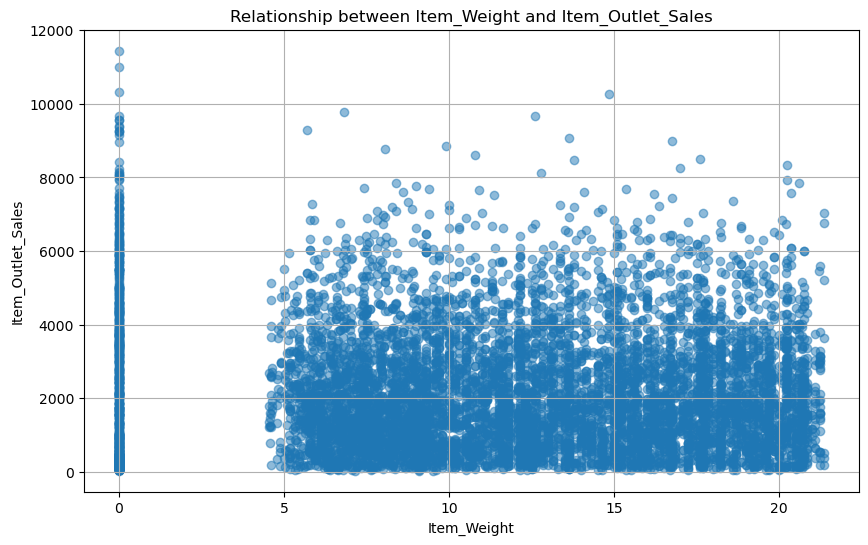

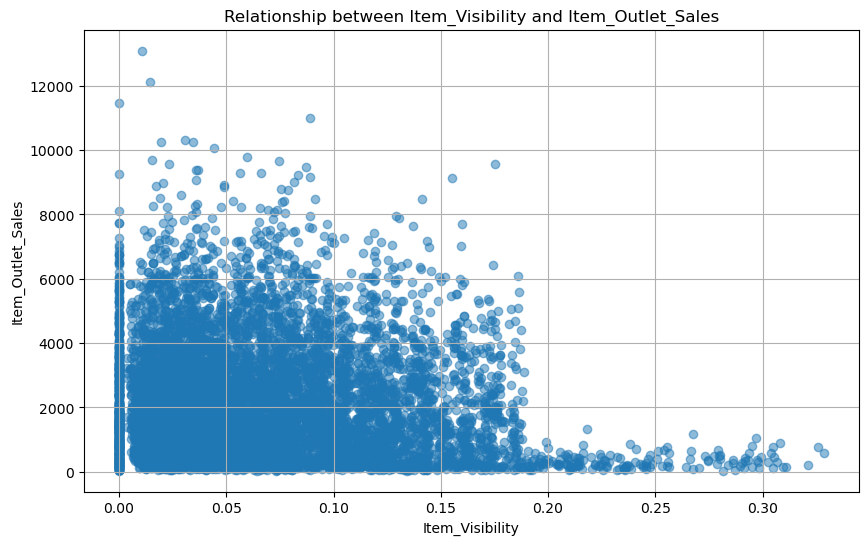

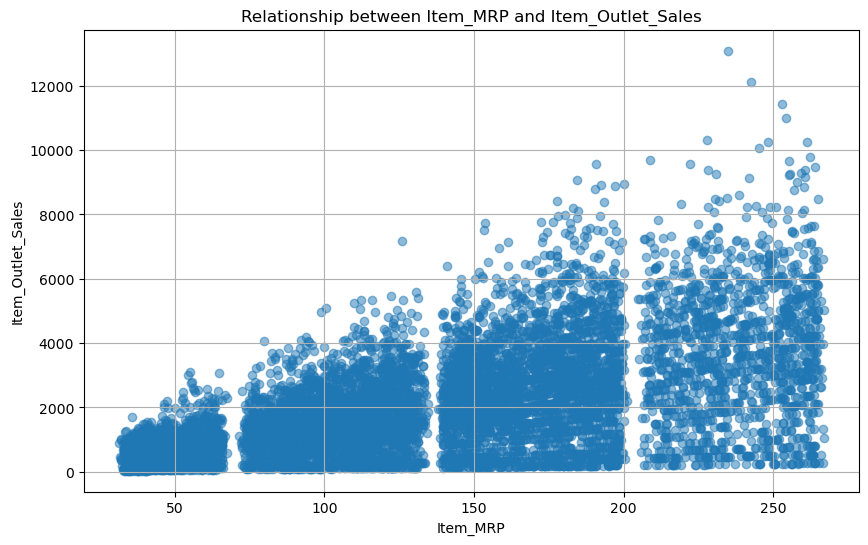

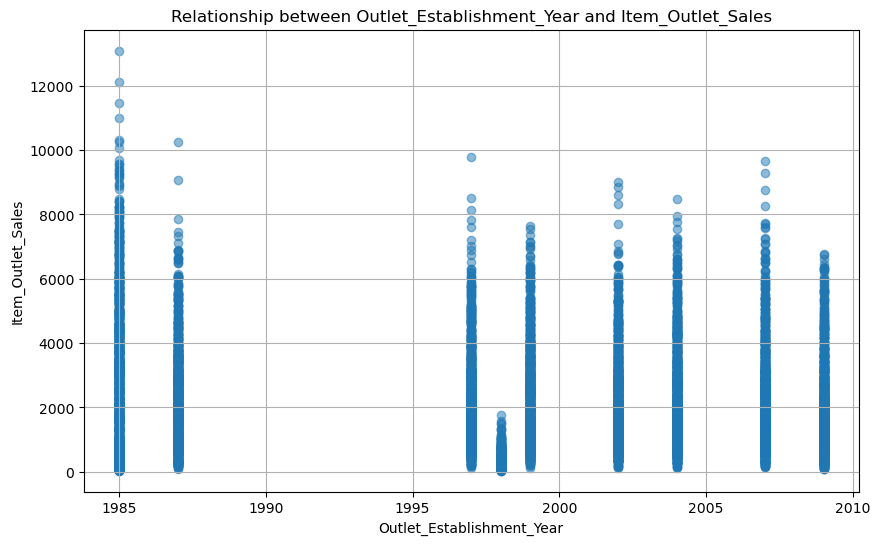

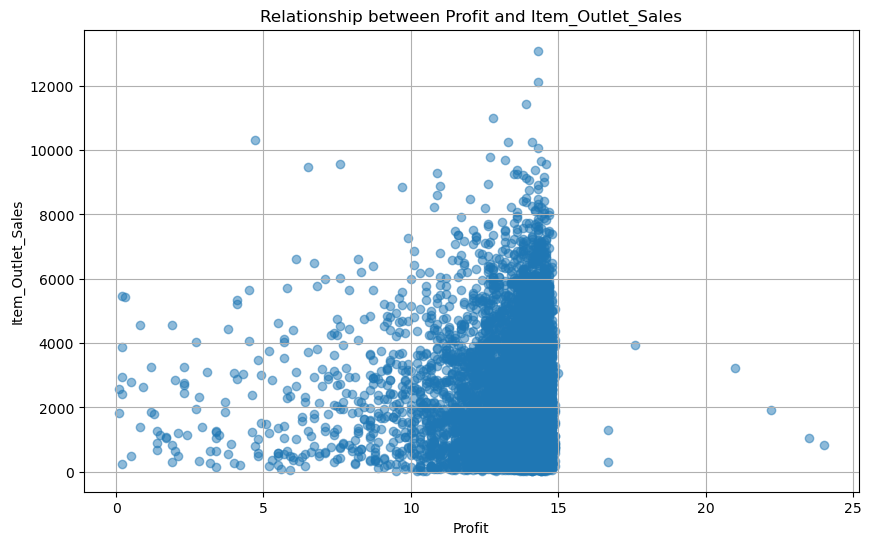

In [5]:
# Selecting numeric features excluding the target 'Item_Outlet_Sales'
features = bigmart_data.select_dtypes(include=[np.number]).drop(columns=['Item_Outlet_Sales'])

# Plotting scatter plots for each numeric feature against 'Item_Outlet_Sales'
for feature in features.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(bigmart_data[feature], bigmart_data['Item_Outlet_Sales'], alpha=0.5)
    plt.title(f'Relationship between {feature} and Item_Outlet_Sales')
    plt.xlabel(feature)
    plt.ylabel('Item_Outlet_Sales')
    plt.grid(True)
    plt.show()

### EDA of categorical features

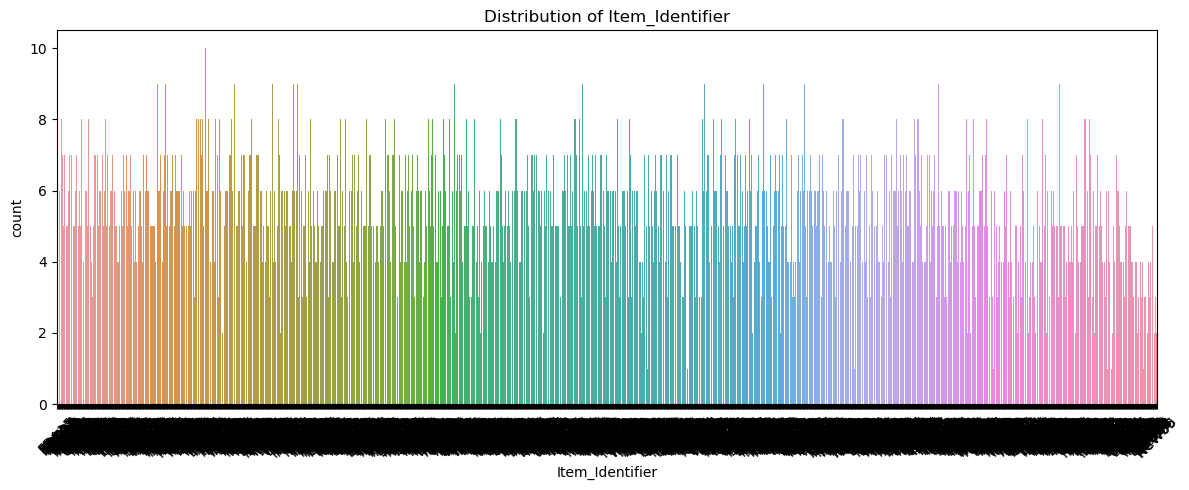

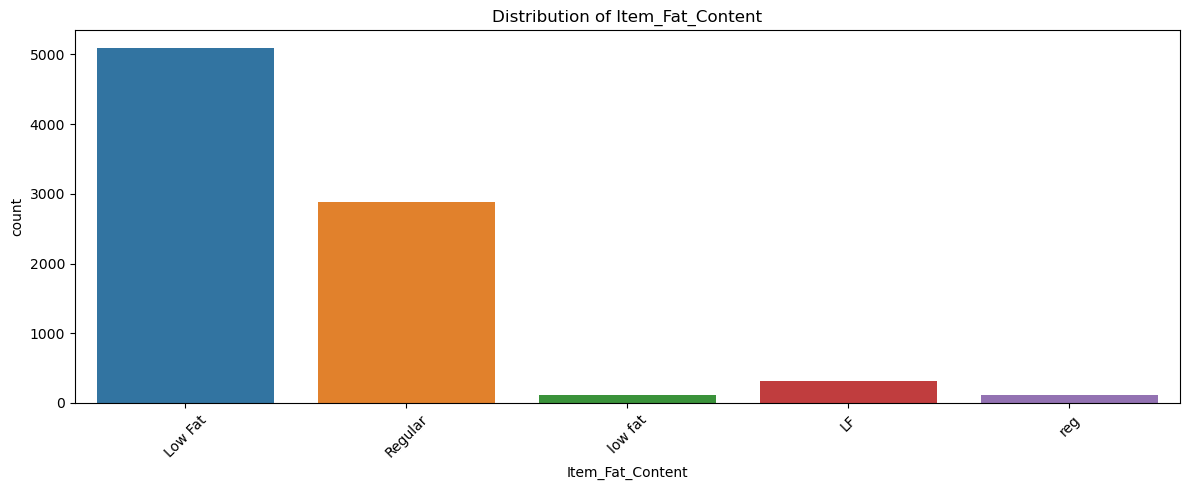

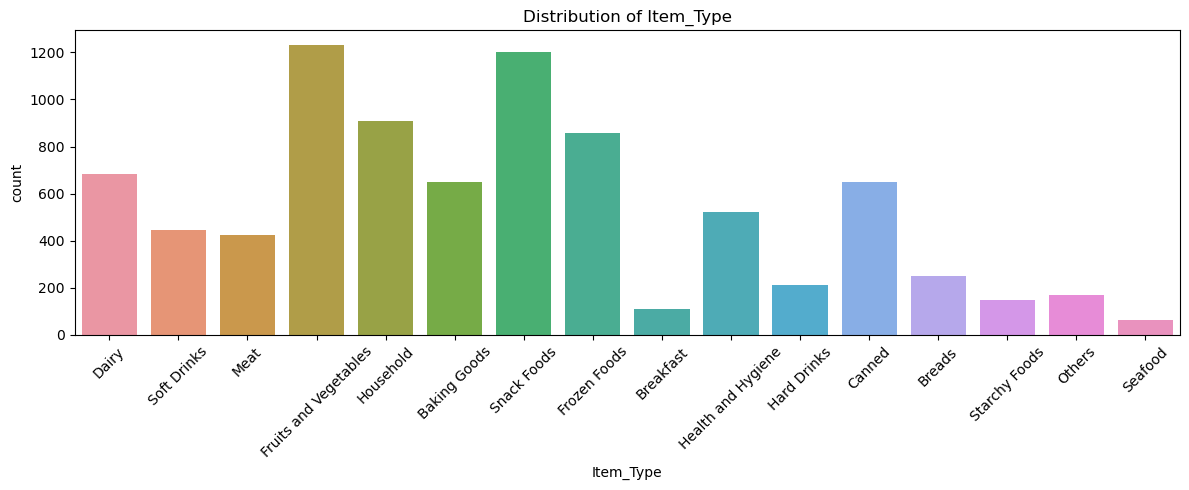

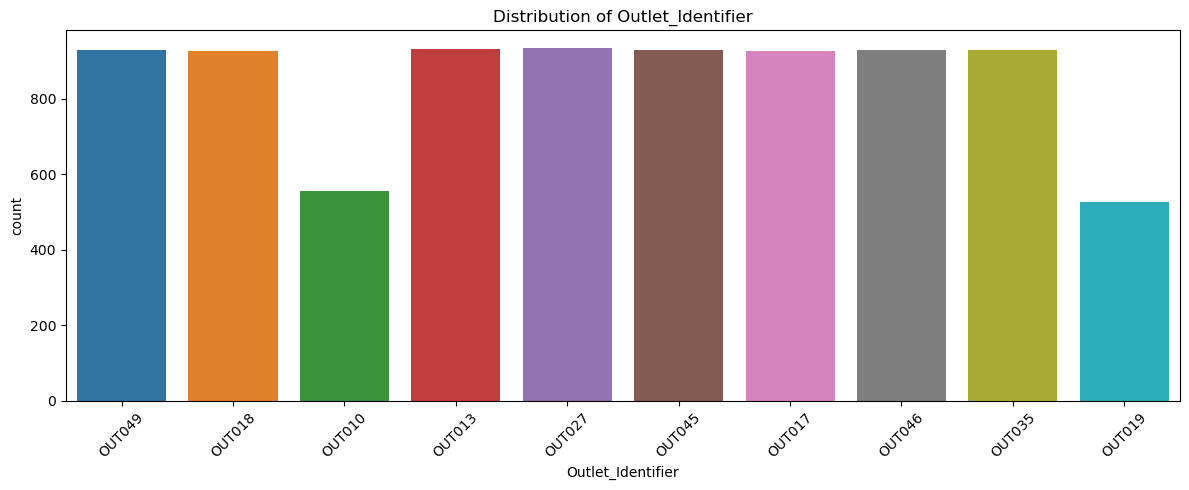

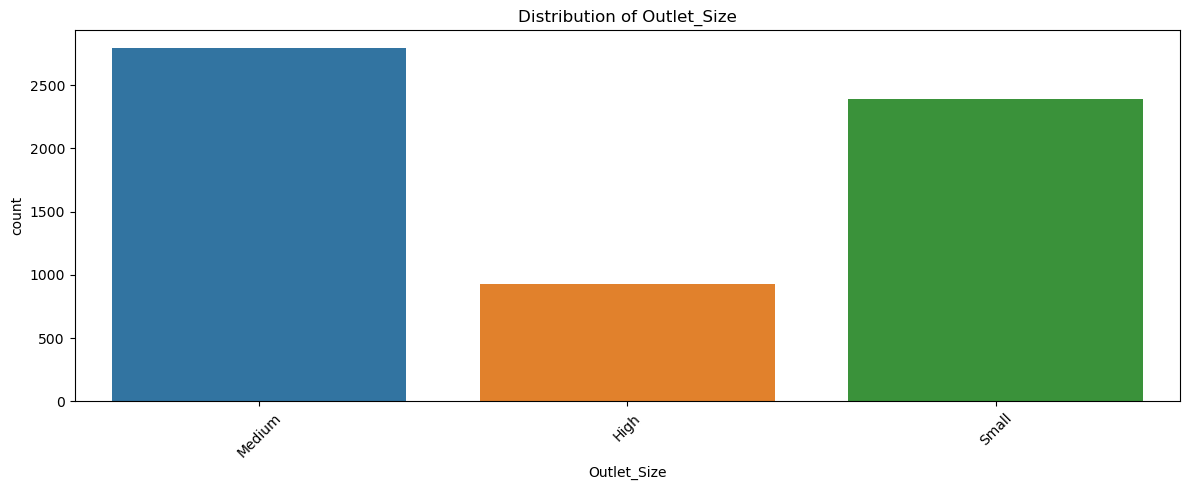

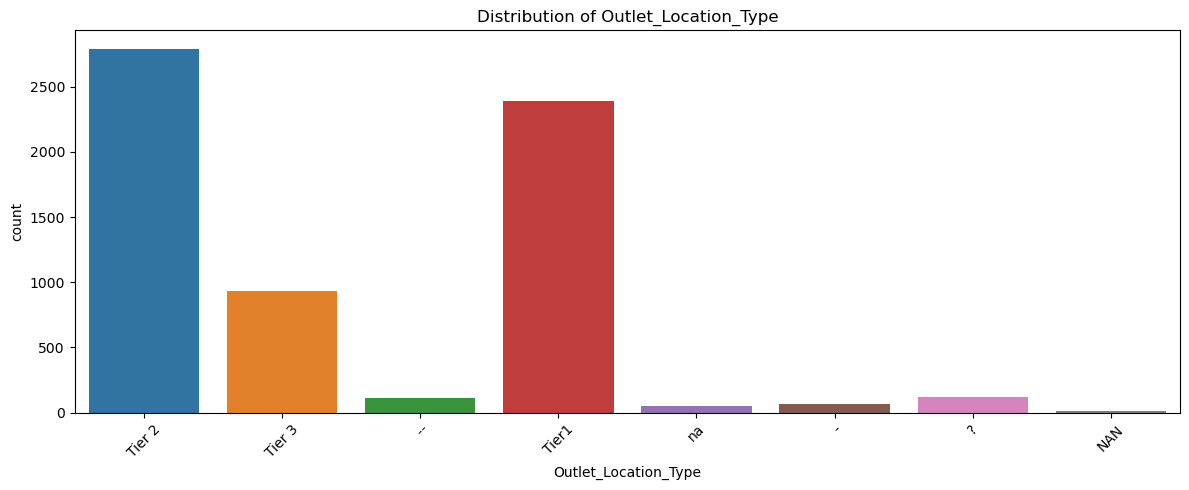

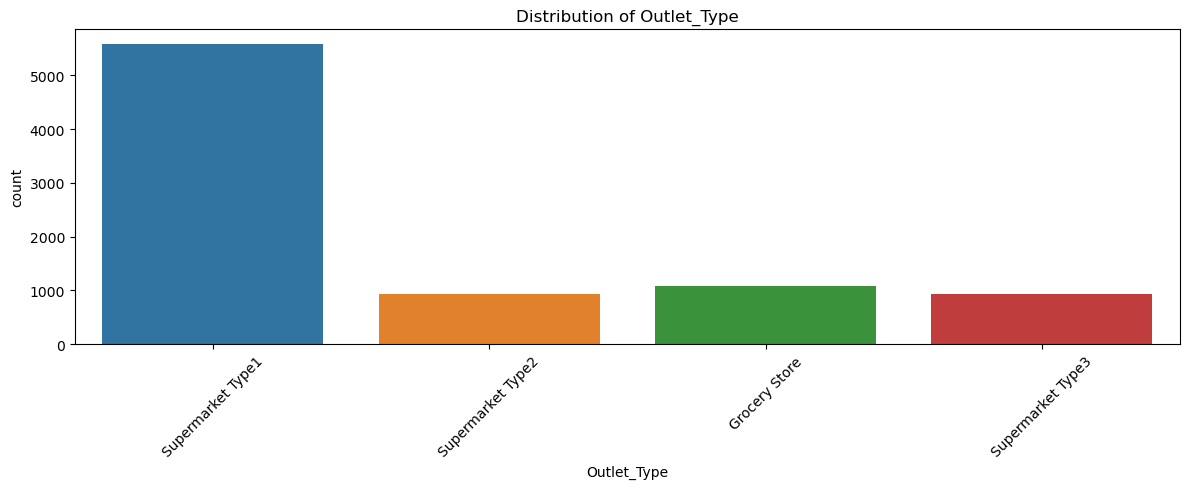

In [6]:

categorical_features = bigmart_data.select_dtypes(exclude=[np.number])

# Countplot for all categorical features
for feature in categorical_features.columns:
    plt.figure(figsize=(12, 5))
    sns.countplot(data=bigmart_data, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


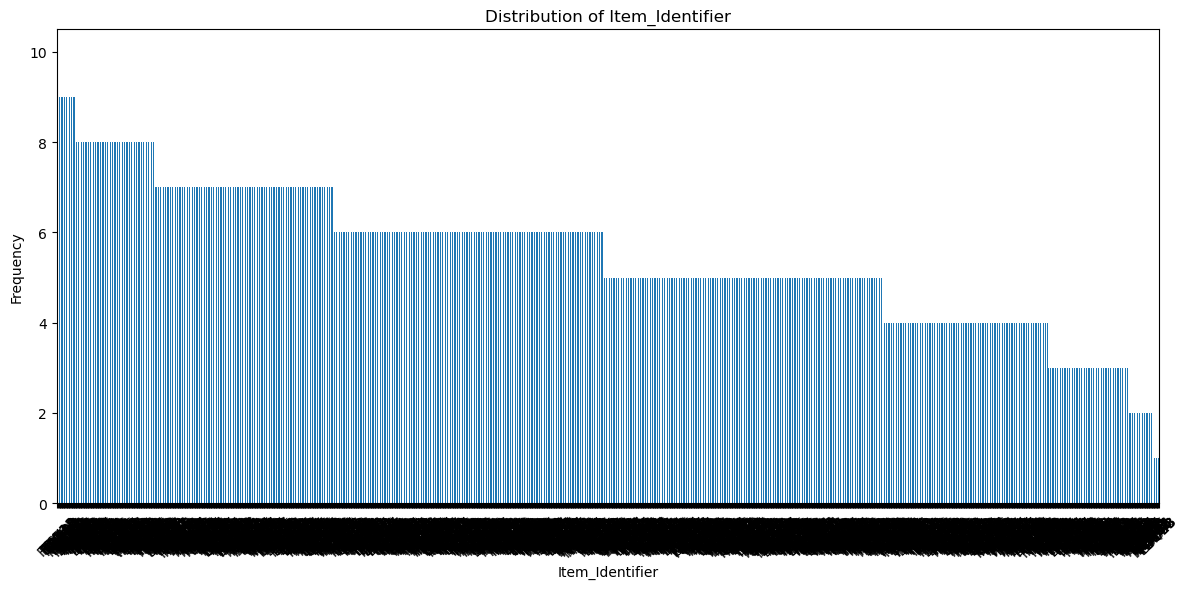

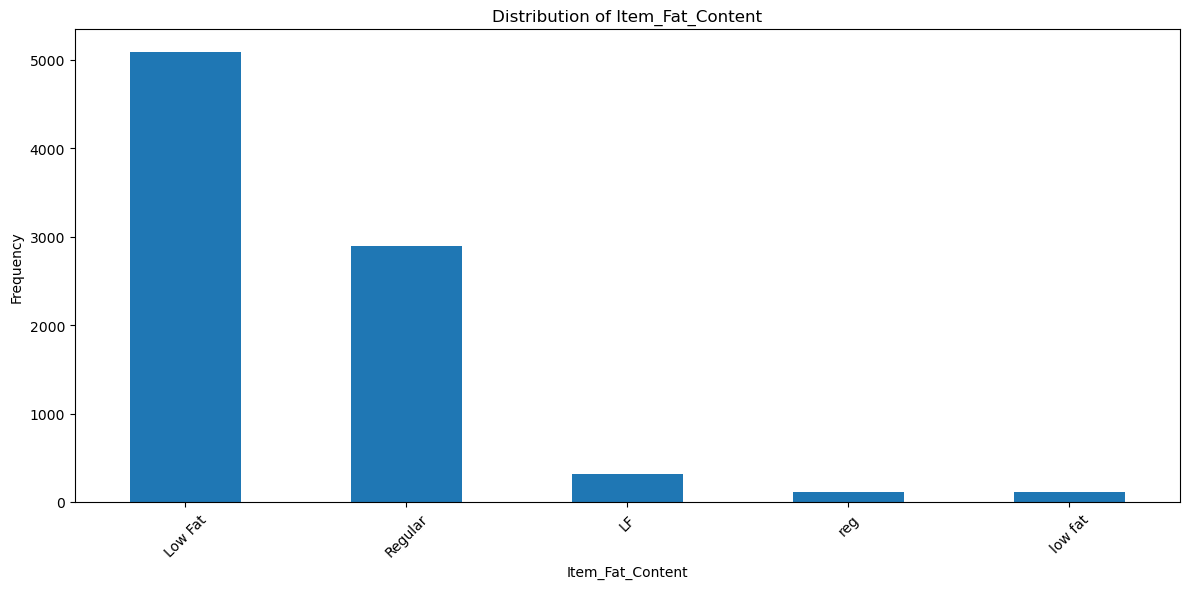

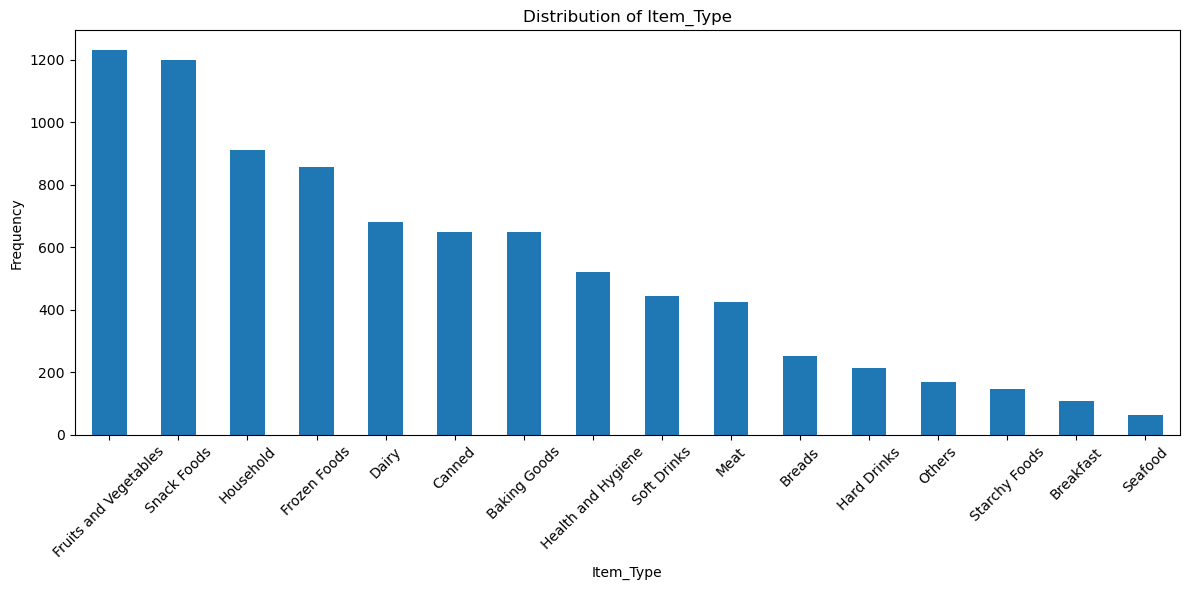

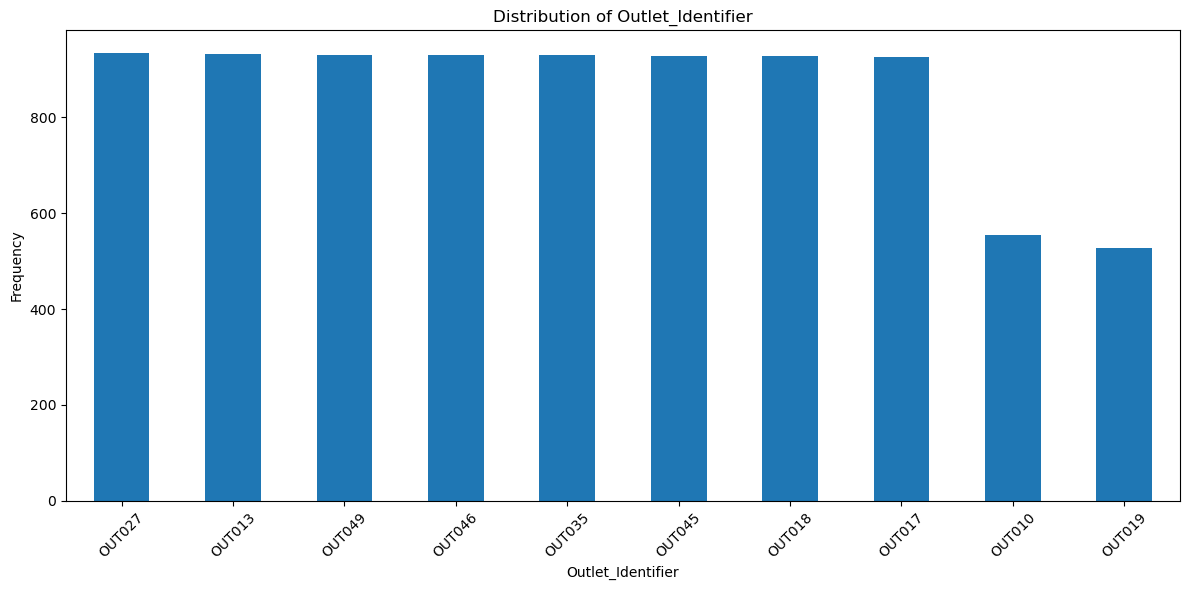

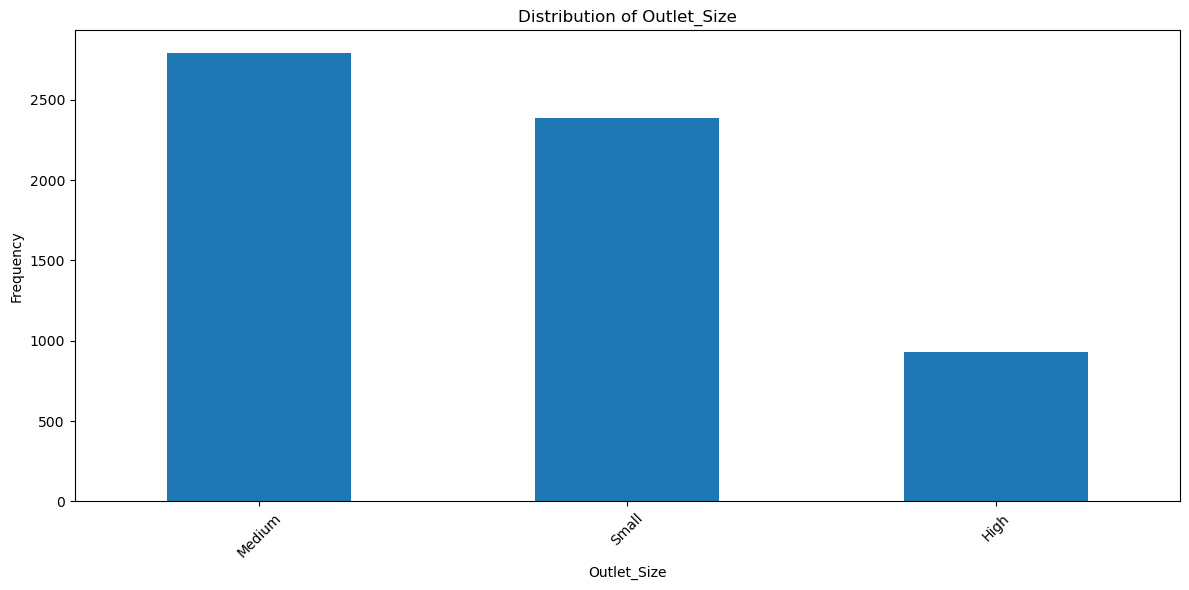

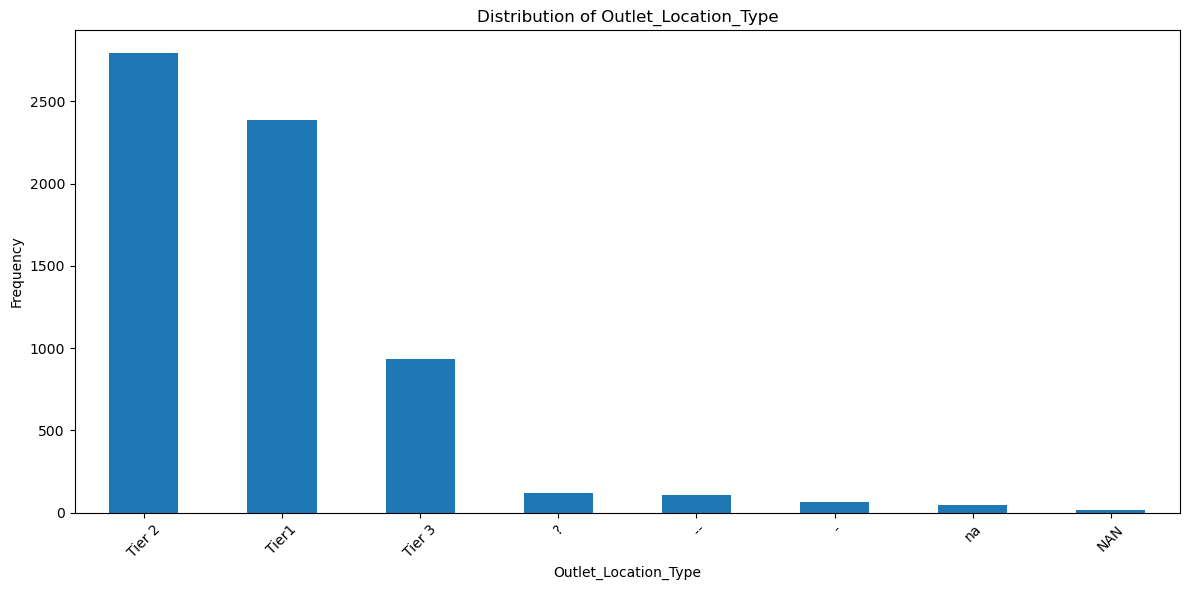

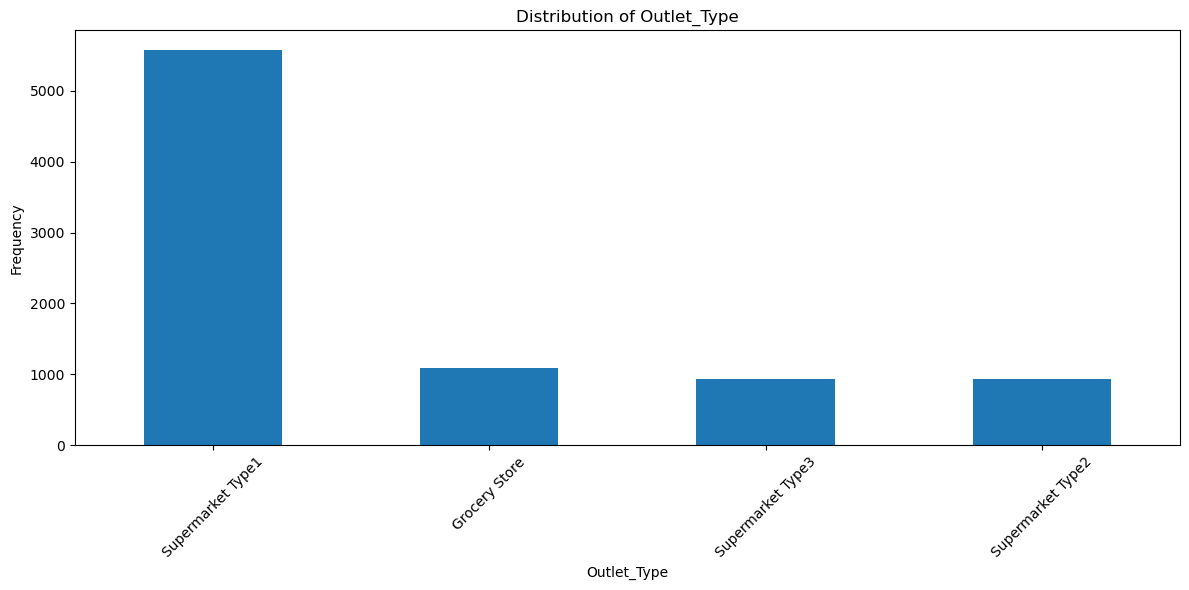

In [7]:
# Selecting categorical features
categorical_features = bigmart_data.select_dtypes(exclude=[np.number])

# Plotting bar charts for each categorical feature
for feature in categorical_features.columns:
    plt.figure(figsize=(12, 6))
    bigmart_data[feature].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {feature}')
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

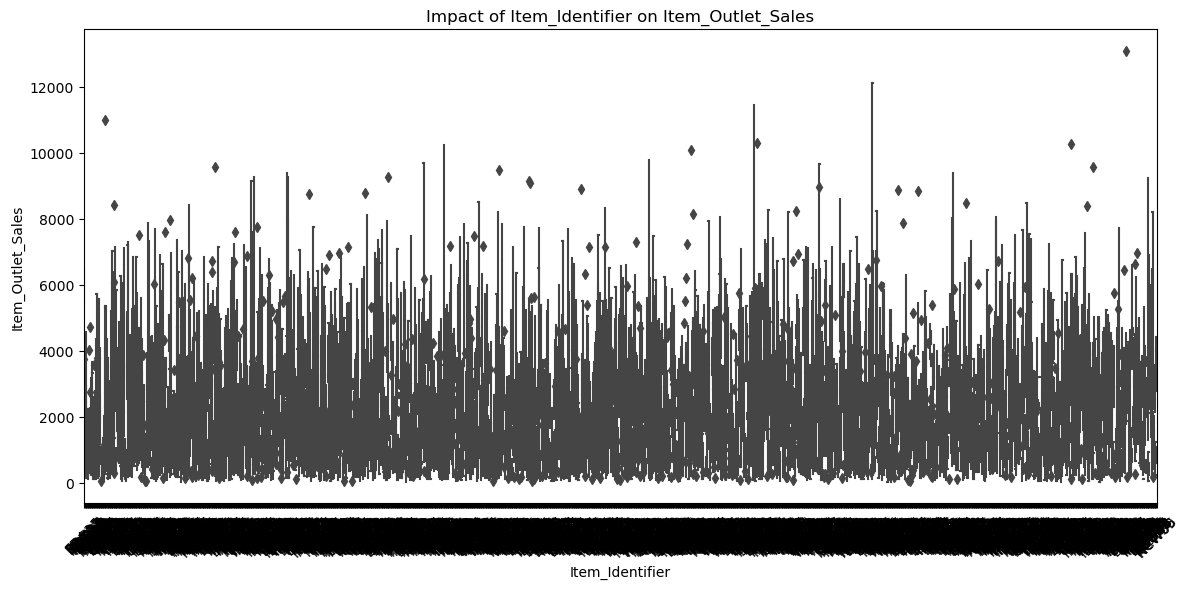

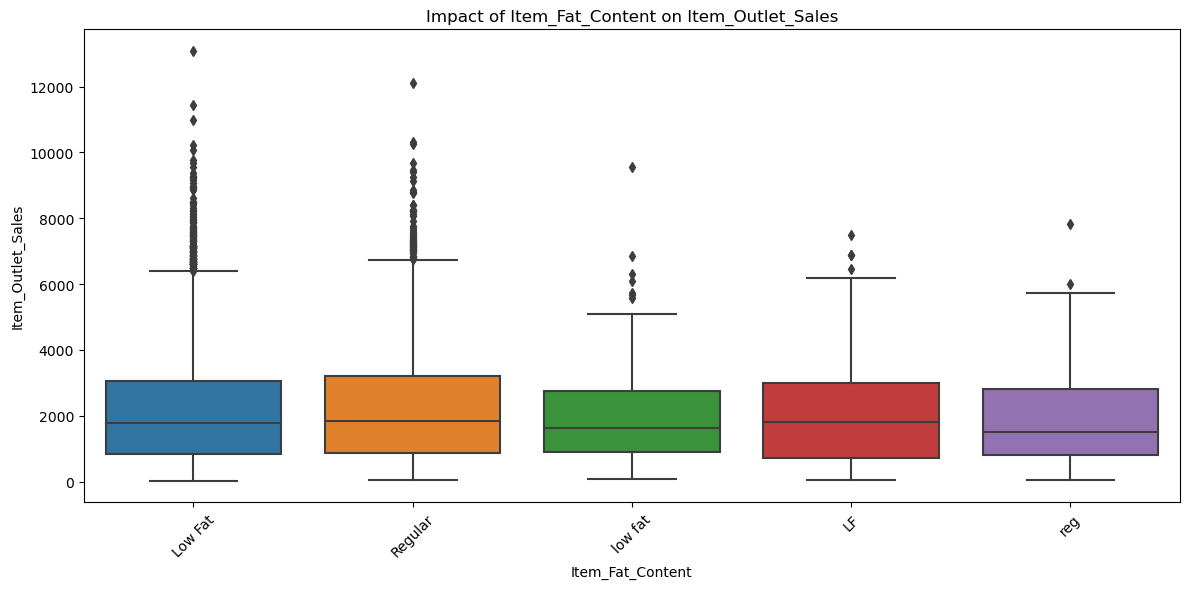

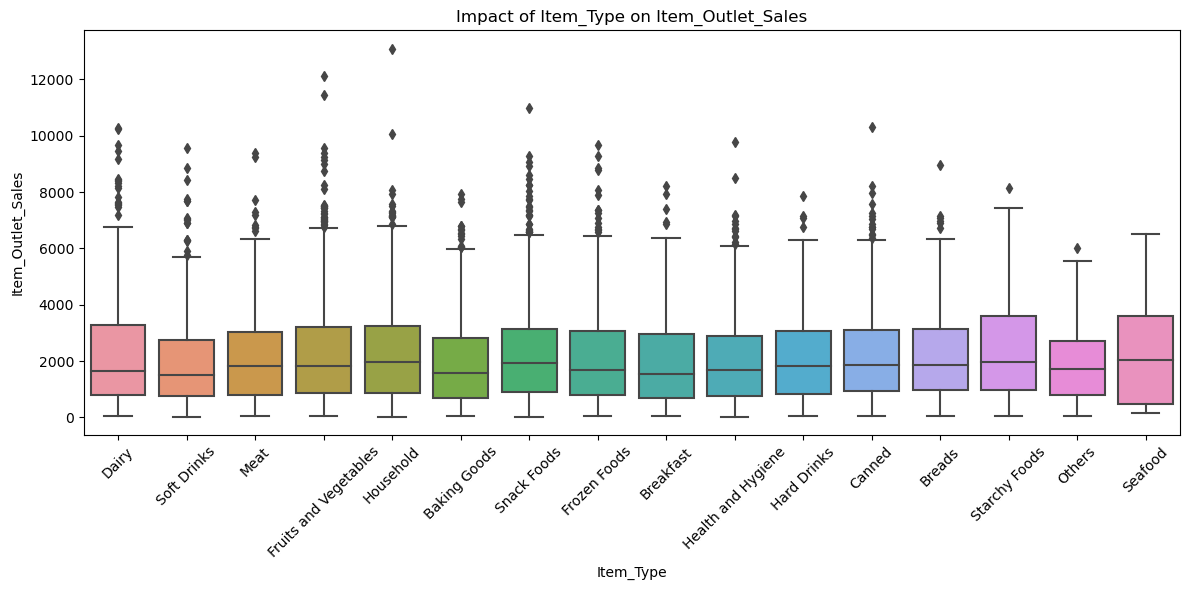

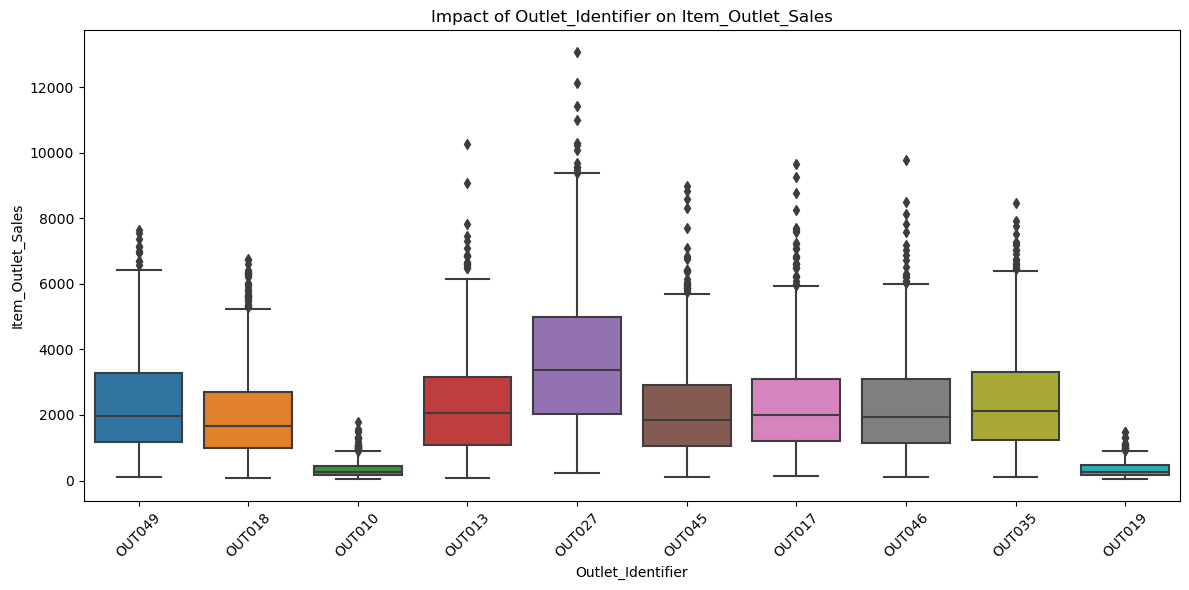

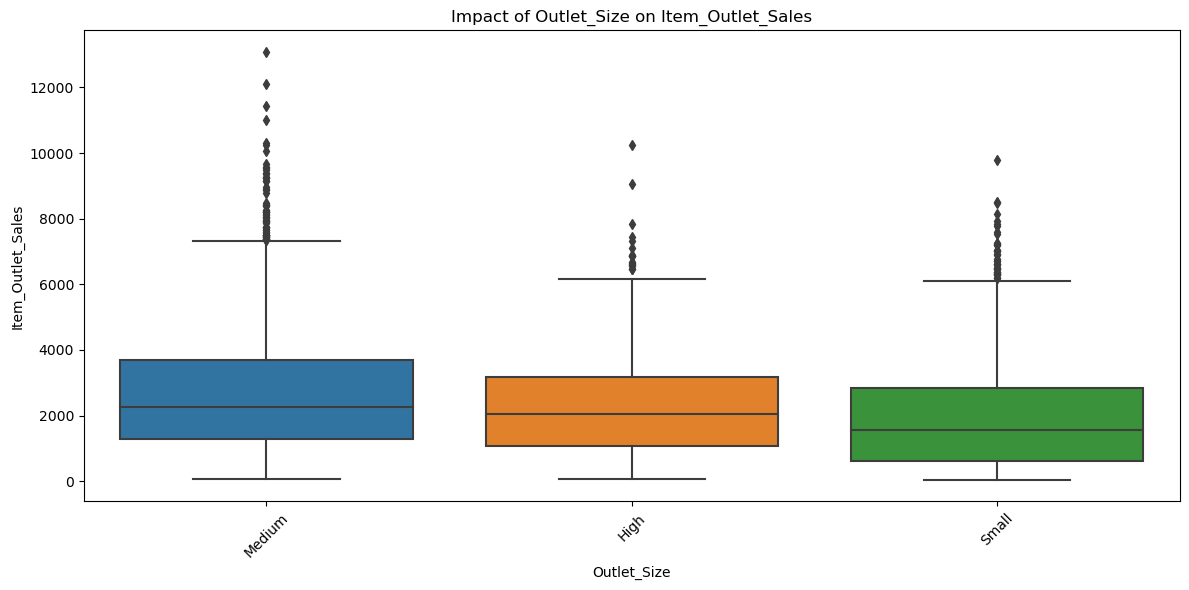

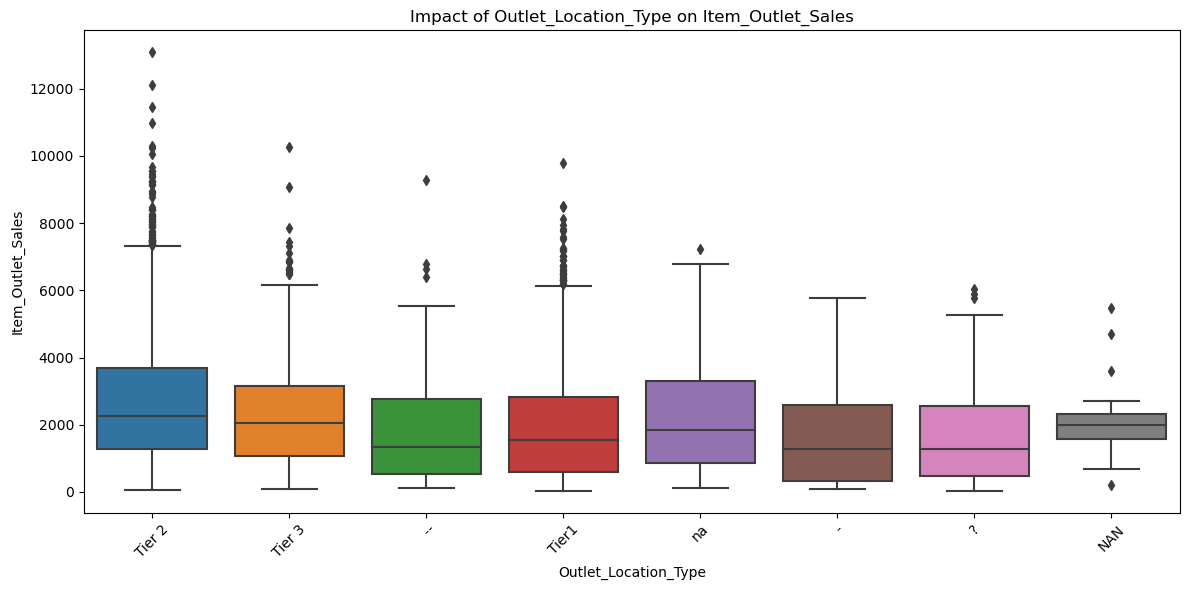

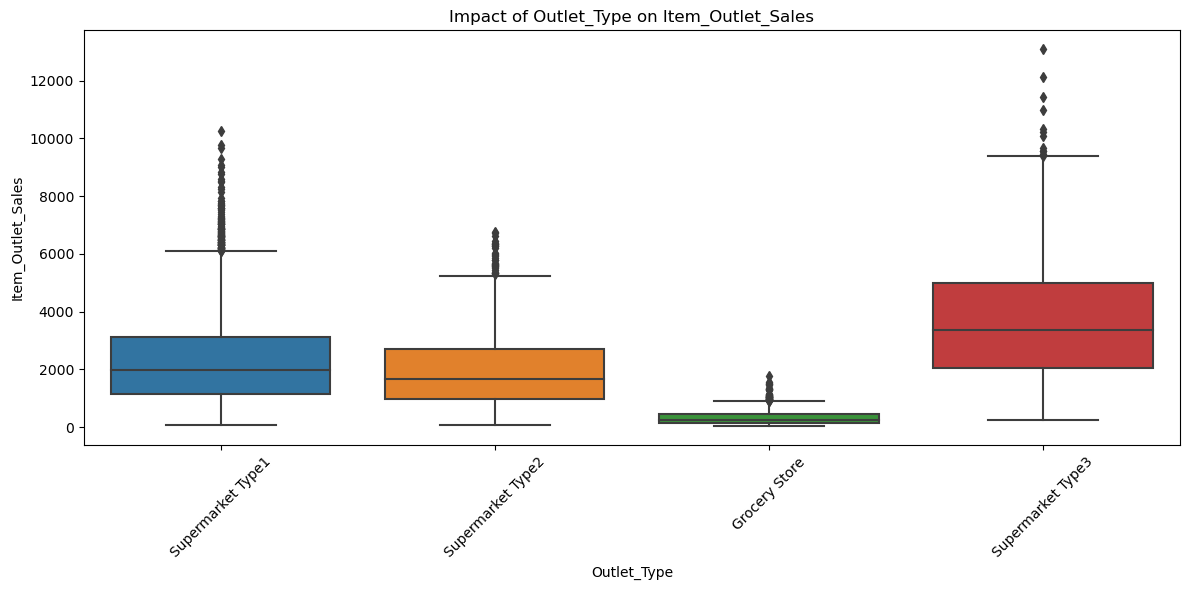

In [8]:
# Selecting categorical features
categorical_features = bigmart_data.select_dtypes(exclude=[np.number])

# Plotting box plots for each categorical feature against 'Item_Outlet_Sales'
for feature in categorical_features.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=bigmart_data, x=feature, y='Item_Outlet_Sales')
    plt.title(f'Impact of {feature} on Item_Outlet_Sales')
    plt.ylabel('Item_Outlet_Sales')
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 2. Deal with Missings

Identify columns with missing values and decide on strategies to handle them.

In [9]:
# Check for missing values
missing_values = bigmart_data.isnull().sum()
missing_values[missing_values > 0]

Item_Weight              749
Outlet_Size             2410
Outlet_Location_Type    2050
dtype: int64

### For imputation, we have several strategies:

**Item_Weight:** We can replace missing values with the mean or median of the Item_Weight column.

**Outlet_Size:** Since it's a categorical variable, we can replace missing values with the mode (most frequent category) of the Outlet_Size column.

**Outlet_Location_Type:** Similarly, being a categorical variable, we can use the mode for imputation.

In [10]:
# Imputation for 'Item_Weight' using the mean
bigmart_data['Item_Weight'].fillna(bigmart_data['Item_Weight'].mean(), inplace=True)

# Imputation for 'Outlet_Size' using the mode
bigmart_data['Outlet_Size'].fillna(bigmart_data['Outlet_Size'].mode()[0], inplace=True)

# Imputation for 'Outlet_Location_Type' using the mode
bigmart_data['Outlet_Location_Type'].fillna(bigmart_data['Outlet_Location_Type'].mode()[0], inplace=True)

# Verify if missing values are handled
missing_values_after = bigmart_data.isnull().sum()
missing_columns_after = missing_values_after[missing_values_after > 0]
print(missing_columns_after)

Series([], dtype: int64)


# Duplicates and Outliers

### Duplicates
Identify and count duplicate rows.

Remove duplicate rows.

In [11]:
# Identify and count duplicate rows
duplicate_rows = bigmart_data.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_rows}')

# Remove duplicate rows
bigmart_data.drop_duplicates(inplace=True)

# Verify removal of duplicates
duplicate_rows_after = bigmart_data.duplicated().sum()
print(f'Number of duplicate rows after removal: {duplicate_rows_after}')

Number of duplicate rows: 0
Number of duplicate rows after removal: 0


### Outliers

Visualize the distribution of numerical features using box plots to identify potential outliers.

Decide on a strategy to handle outliers (e.g., removal, capping, or transformation).

/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


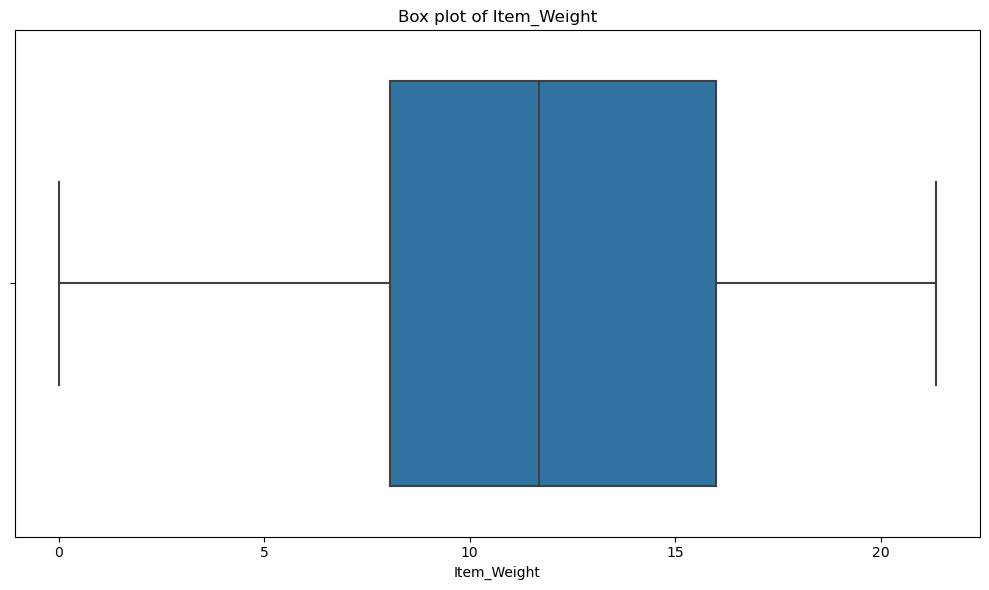

/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


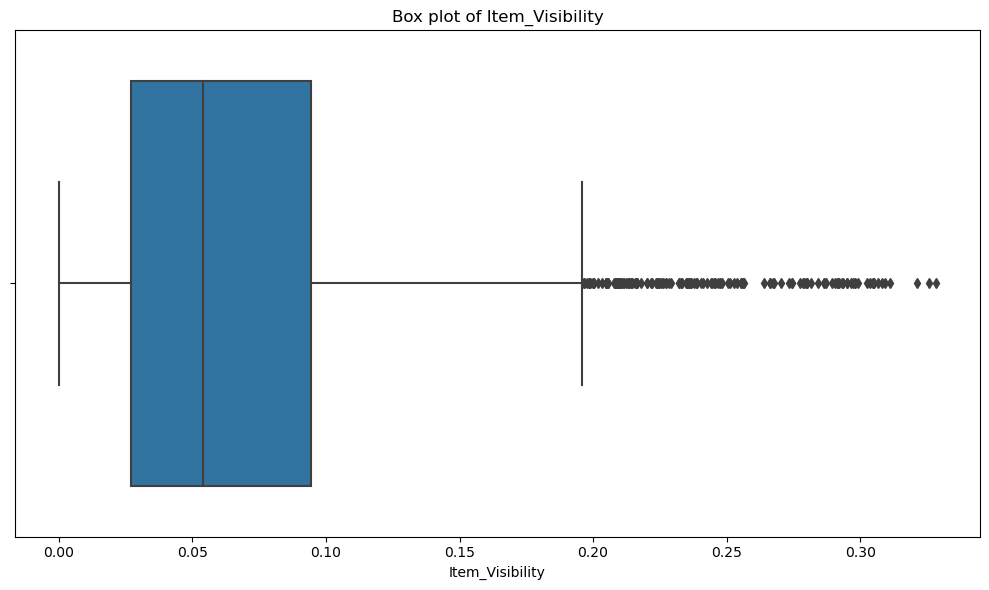

/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


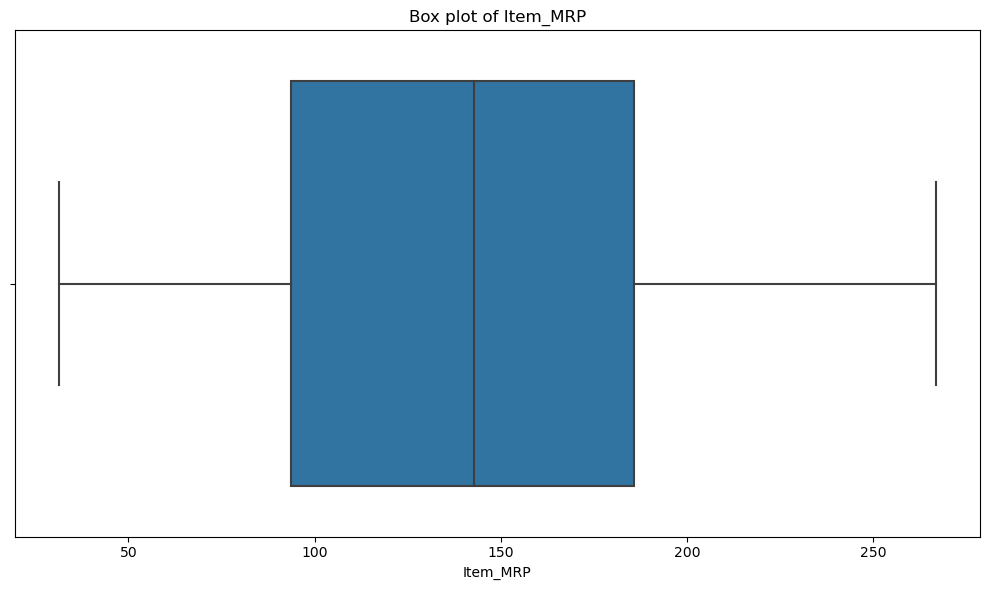

/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


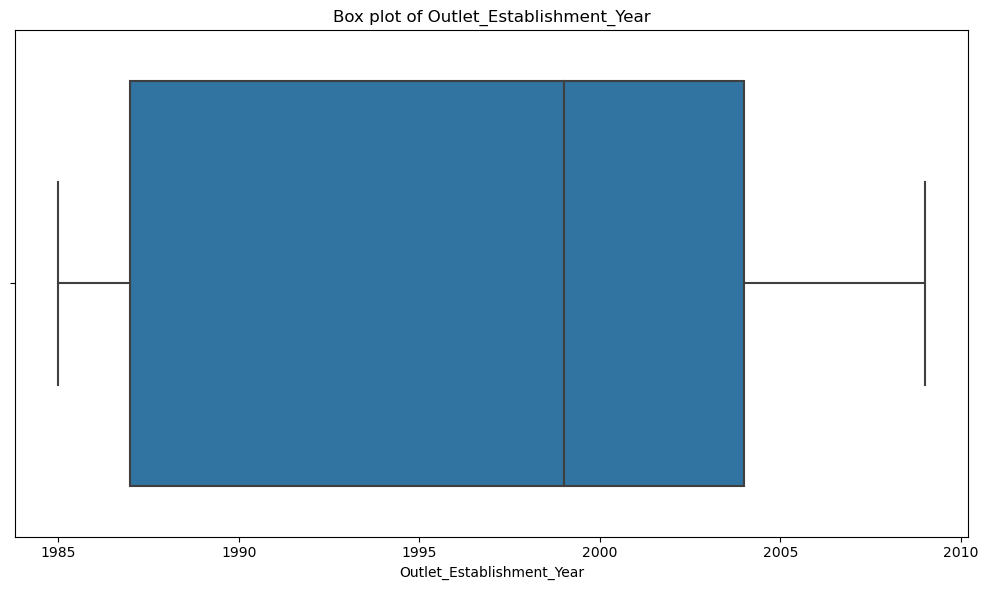

/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


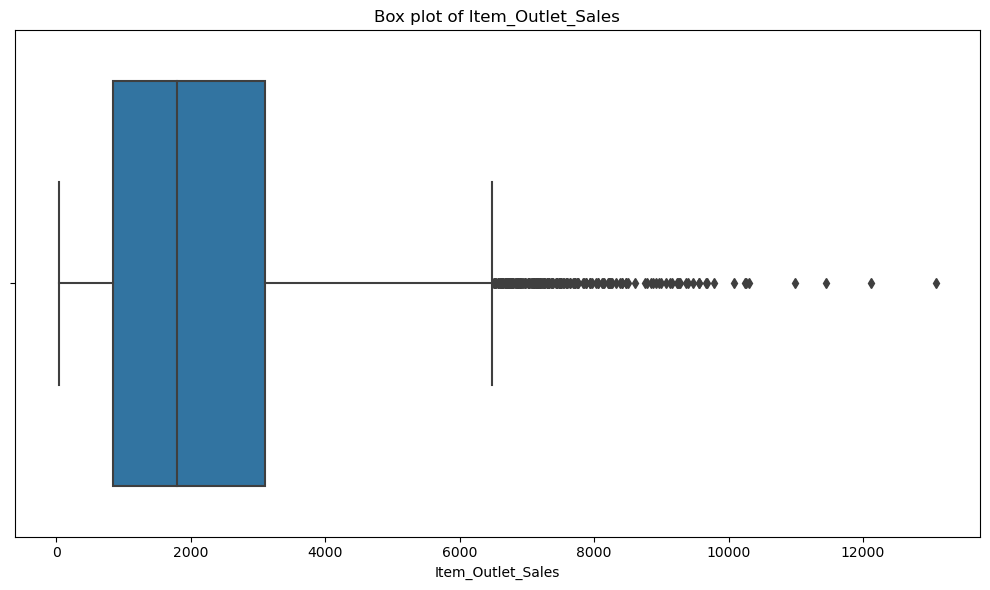

/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


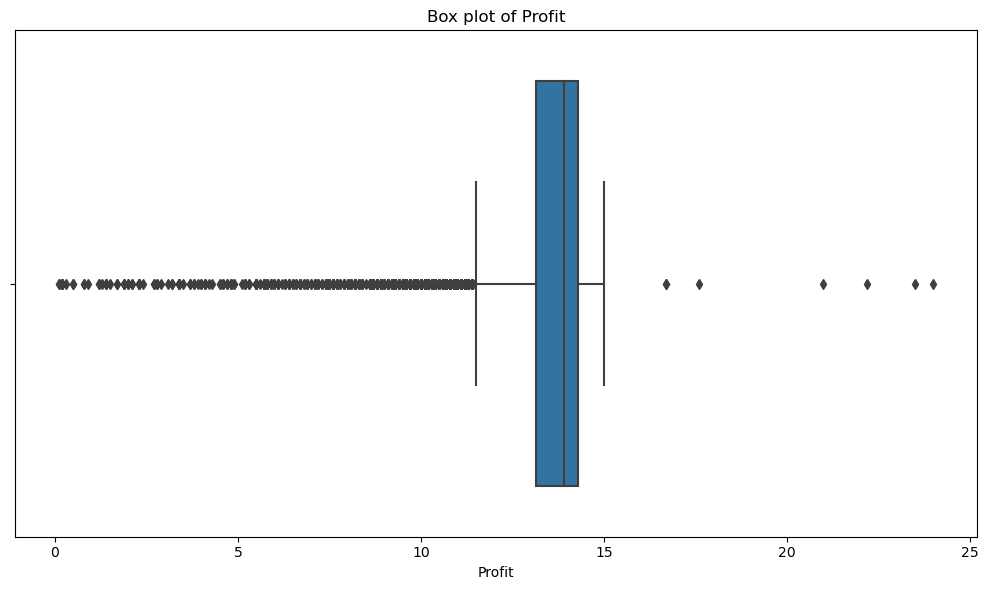

In [12]:
# Selecting numeric features from the dataset
numeric_features = bigmart_data.select_dtypes(include=[np.number])

# Plotting box plots for each numeric feature to visualize potential outliers
for feature in numeric_features.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(bigmart_data[feature])
    plt.title(f'Box plot of {feature}')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

After visualizing the outliers, the next steps typically involve deciding how to handle them. Common strategies include:

**Removal:** This involves simply removing the outlier data points. It's a direct method but can lead to a loss of data.

**Capping:** Outliers are set to a particular maximum or minimum value. This can be set based on domain knowledge or specific percentiles.

**Transformation:** Applying transformations like log, square root, or others to compress the extreme values.
**Binning:** Convert continuous variables into categorical counterparts by creating intervals.

To proceed, we first need to define what we consider an "outlier." A common method is to use the IQR (Interquartile Range) rule:

Any value below Q1−1.5×IQR or above Q3+1.5×IQR is considered an outlier, where Q1 and Q3 are the first and third quartiles, respectively.

In [13]:
# Function to detect outliers based on IQR
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

outliers_detected = numeric_features.apply(detect_outliers)
outliers_count = outliers_detected.sum()
print(outliers_count)

Item_Weight                    0
Item_Visibility              144
Item_MRP                       0
Outlet_Establishment_Year      0
Item_Outlet_Sales            186
Profit                       705
dtype: int64


Transformations can be an effective way to manage outliers, especially for data that is skewed. Common transformations include:

**Log Transformation:** Useful for right-skewed data.
    
**Square Root Transformation:** Helps to reduce the impact of extreme values.
    
**Box-Cox Transformation:** A family of power transformations that can stabilize variance and make the data more normal in distribution.

Given the nature of sales data and the usual presence of zero values in features like Item_Visibility, the log transformation might be tricky due to the logarithm of zero being undefined. Therefore, we can use a slight adjustment by adding a small constant to ensure there are no zero values.

Let's start by visualizing the distribution of these features using histograms to determine their skewness and then decide on an appropriate transformation.

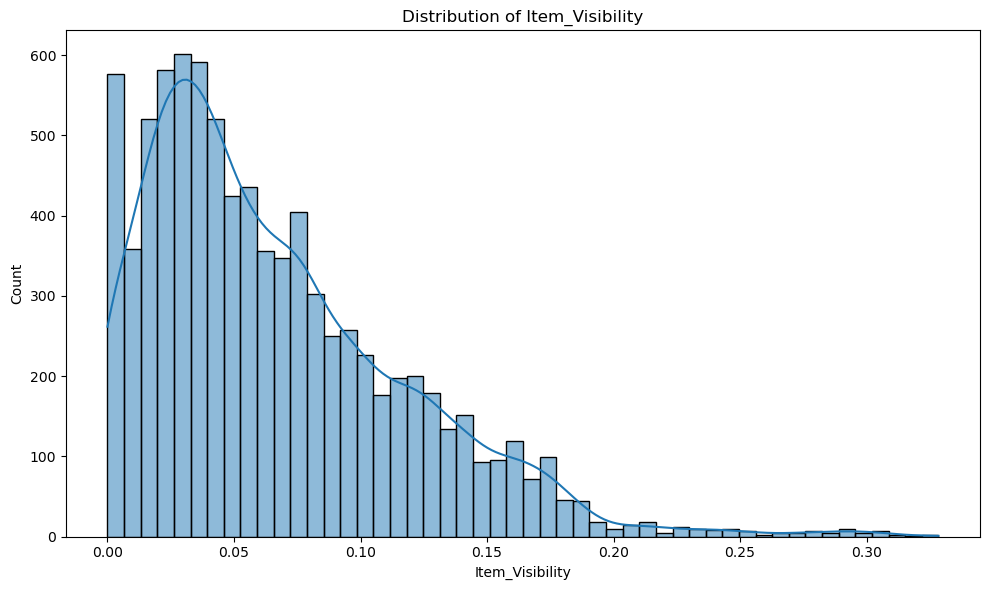

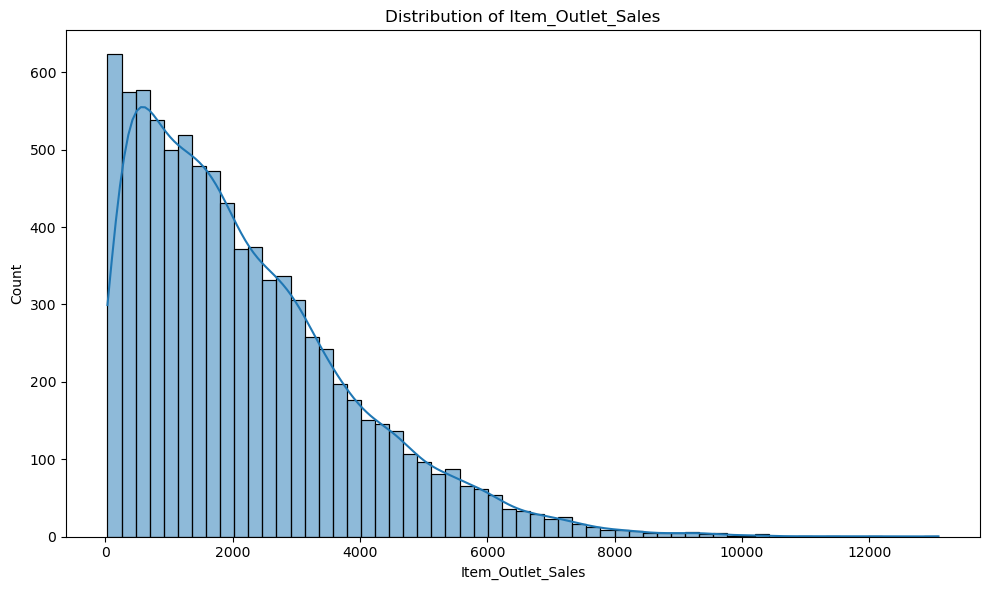

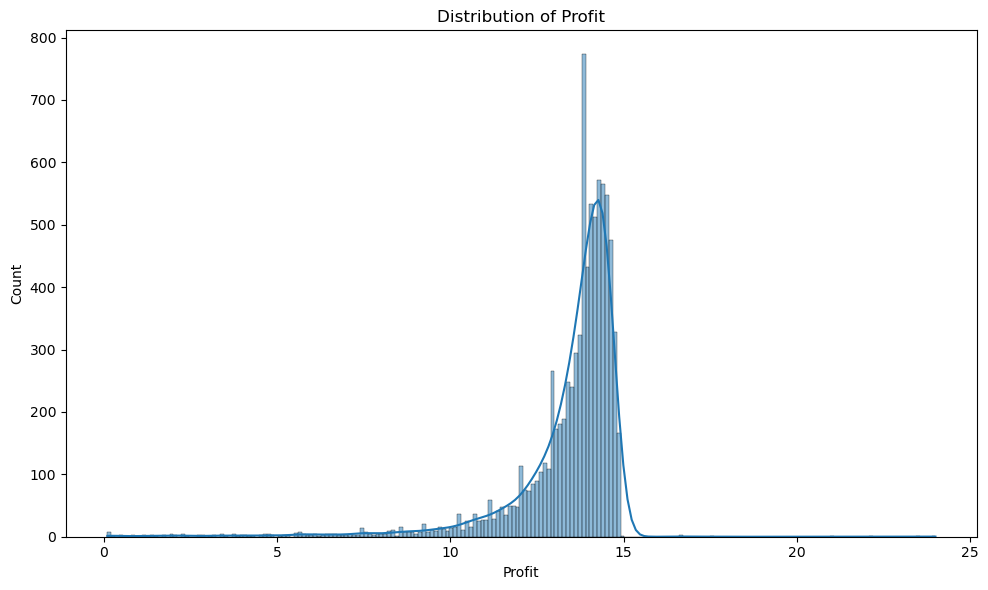

In [14]:
features_to_transform = ['Item_Visibility', 'Item_Outlet_Sales', 'Profit']

# Plotting histograms for the specified features
for feature in features_to_transform:
    plt.figure(figsize=(10, 6))
    sns.histplot(bigmart_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

The Box-Cox transformation is indeed a powerful method to handle skewed data. It's defined as:

$$
\begin{equation}
y_{\text{transformed}} =
\begin{cases}
\frac{y^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
\ln(y), & \text{if } \lambda = 0
\end{cases}
\end{equation}
$$

Where:

Y is the data you want to transform.

λ is the transformation parameter.

The Box-Cox transformation requires all data to be positive. So before applying it, we'll ensure the data is positive. Also, we'll use the scipy library's boxcox function, which automatically finds the lambda that maximizes the normality of the data.

Here's the Python code to apply the Box-Cox transformation to the specified features:

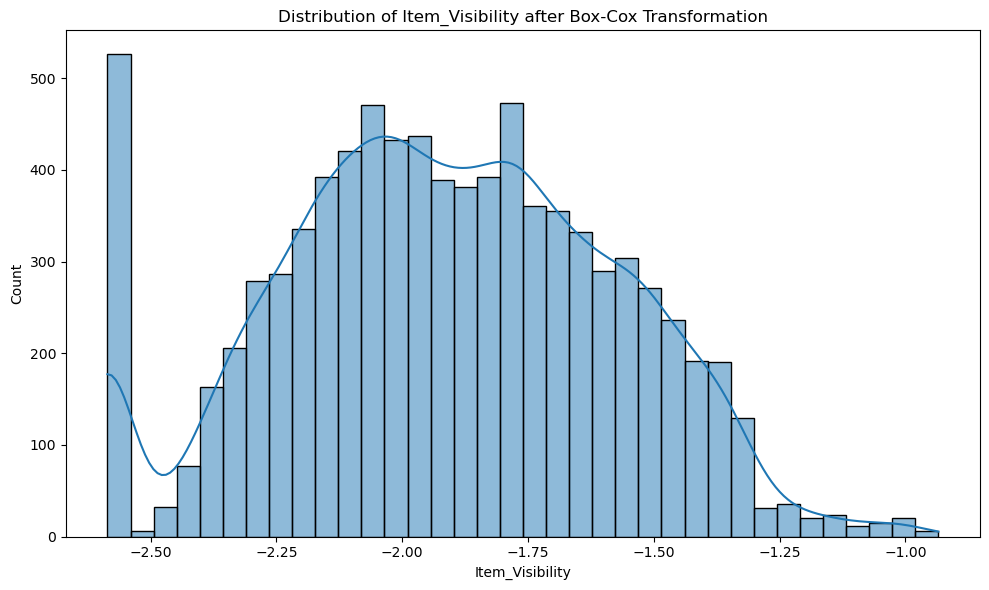

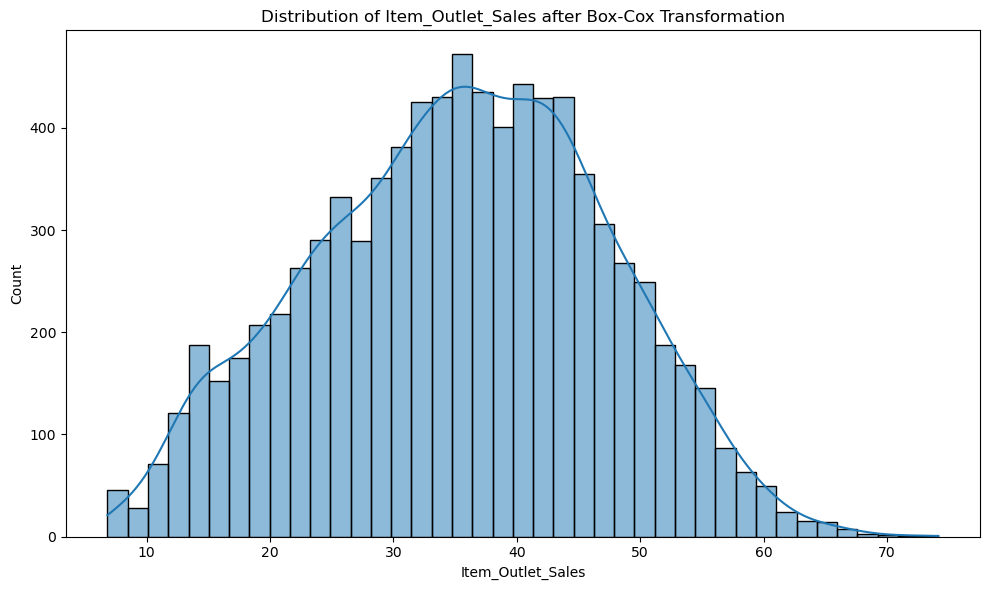

In [15]:
features_to_transform = ['Item_Visibility', 'Item_Outlet_Sales']

# Ensure data is positive by adding a small constant to 'Item_Visibility'
bigmart_data['Item_Visibility'] = bigmart_data['Item_Visibility'] + 0.01

# Applying Box-Cox transformation
for feature in features_to_transform:
    bigmart_data[feature], _ = boxcox(bigmart_data[feature])


for feature in features_to_transform:
    plt.figure(figsize=(10, 6))
    sns.histplot(bigmart_data[feature], kde=True)
    plt.title(f'Distribution of {feature} after Box-Cox Transformation')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()


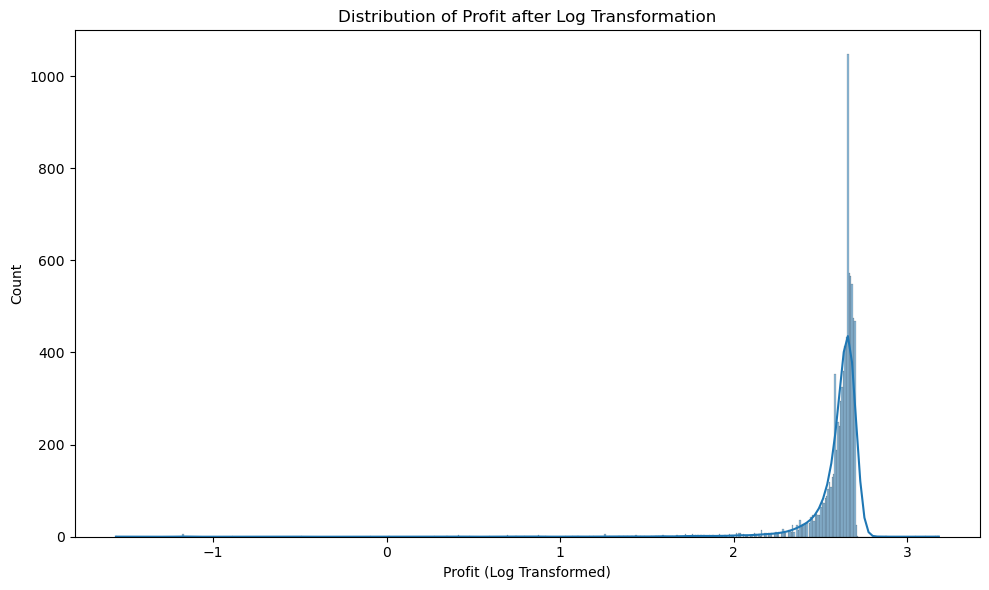

In [16]:
# Ensure all values are positive by adding a small constant to 'Profit'
bigmart_data['Profit'] = bigmart_data['Profit'] + abs(bigmart_data['Profit'].min()) + 0.01

# Applying the log transformation
bigmart_data['Profit_log_transformed'] = np.log(bigmart_data['Profit'])

# Visualizing the transformed data
plt.figure(figsize=(10, 6))
sns.histplot(bigmart_data['Profit_log_transformed'], kde=True)
plt.title('Distribution of Profit after Log Transformation')
plt.xlabel('Profit (Log Transformed)')
plt.tight_layout()
plt.show()

The log transformation may not always produce a perfectly normal distribution, especially if the original data is highly skewed or has a complex distribution.

Another transformation you might consider is the inverse transformation, especially when the data is skewed to the right. For data skewed to the left, a square or cube transformation might be effective.

Let's try the inverse transformation on the Profit feature:

Here's the Python code to apply the inverse transformation to the Profit feature:

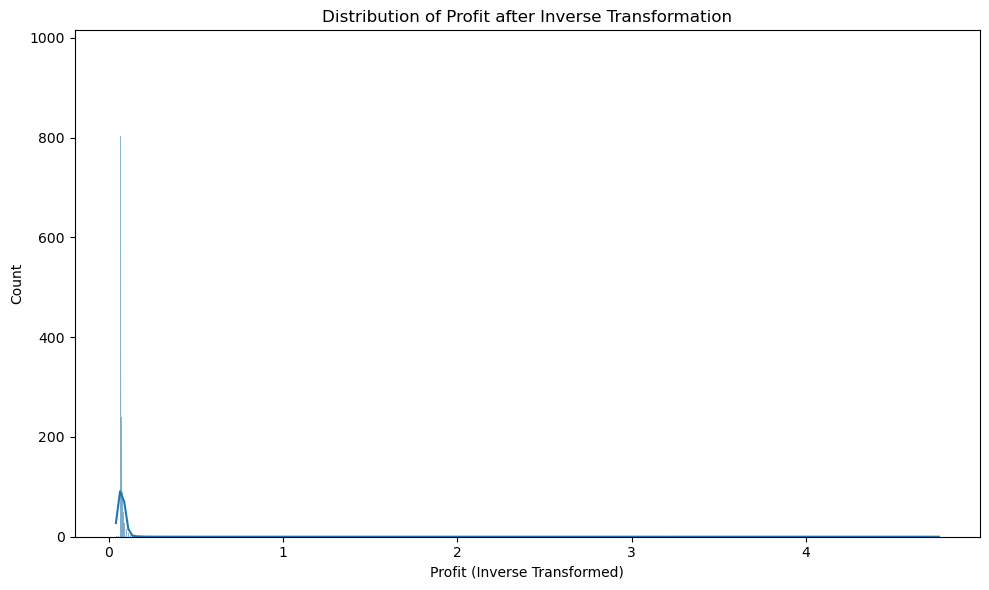

In [17]:
# Applying the inverse transformation to the 'Profit' feature
bigmart_data['Profit_inverse_transformed'] = 1 / bigmart_data['Profit']

# Visualizing the transformed data
plt.figure(figsize=(10, 6))
sns.histplot(bigmart_data['Profit_inverse_transformed'], kde=True)
plt.title('Distribution of Profit after Inverse Transformation')
plt.xlabel('Profit (Inverse Transformed)')
plt.tight_layout()
plt.show()

If the Profit feature has a complicated distribution, common transformations like log and inverse might not produce a perfectly normal distribution. Let's explore a few more alternatives:

**Square Transformation:** For left-skewed data.

**Sqrt Transformation:** For right-skewed data.

**Yeo-Johnson Transformation:** A more flexible method that can handle zeros in the data.

**Quantile Transformer:** Maps the data to a uniform distribution.

Given the right skew, we can try the Sqrt transformation and the Yeo-Johnson transformation. The Quantile Transformer is also worth considering, as it makes fewer assumptions about the functional form of the transformation.

Let's start with the Sqrt transformation on the Profit feature:

Here's the Python code to apply the Sqrt transformation to the Profit feature:

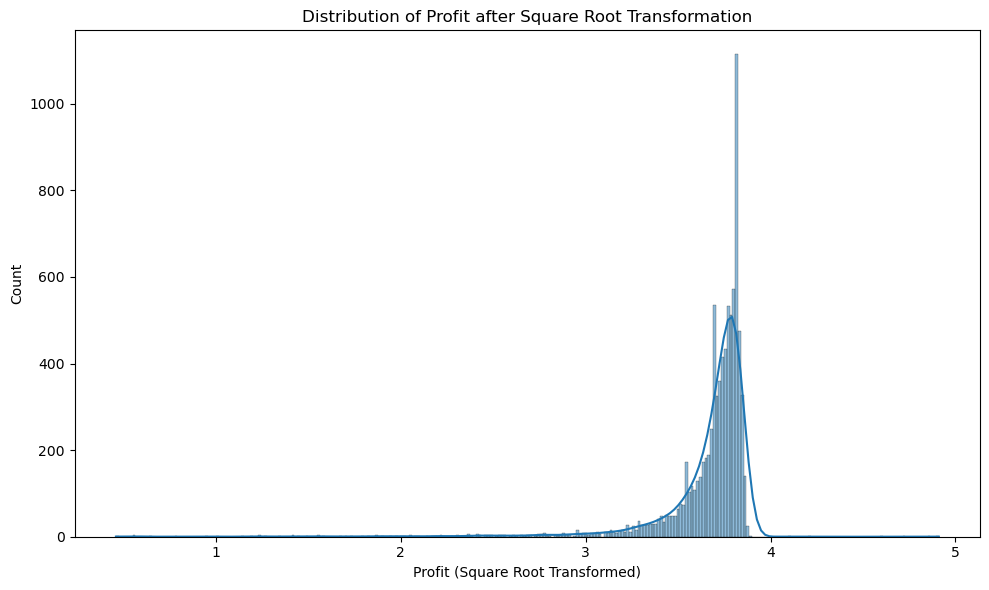

In [18]:
# Applying the square root transformation to the 'Profit' feature
bigmart_data['Profit_sqrt_transformed'] = np.sqrt(bigmart_data['Profit'])

# Visualizing the transformed data
plt.figure(figsize=(10, 6))
sns.histplot(bigmart_data['Profit_sqrt_transformed'], kde=True)
plt.title('Distribution of Profit after Square Root Transformation')
plt.xlabel('Profit (Square Root Transformed)')
plt.tight_layout()
plt.show()

The Yeo-Johnson transformation is a flexible method that can handle both positive and negative values in the data, making it a generalization of the Box-Cox transformation. It's particularly useful when data has zeros or negative values.

Let's apply the Yeo-Johnson transformation to the Profit feature.

Here's the Python code to apply the Yeo-Johnson transformation:

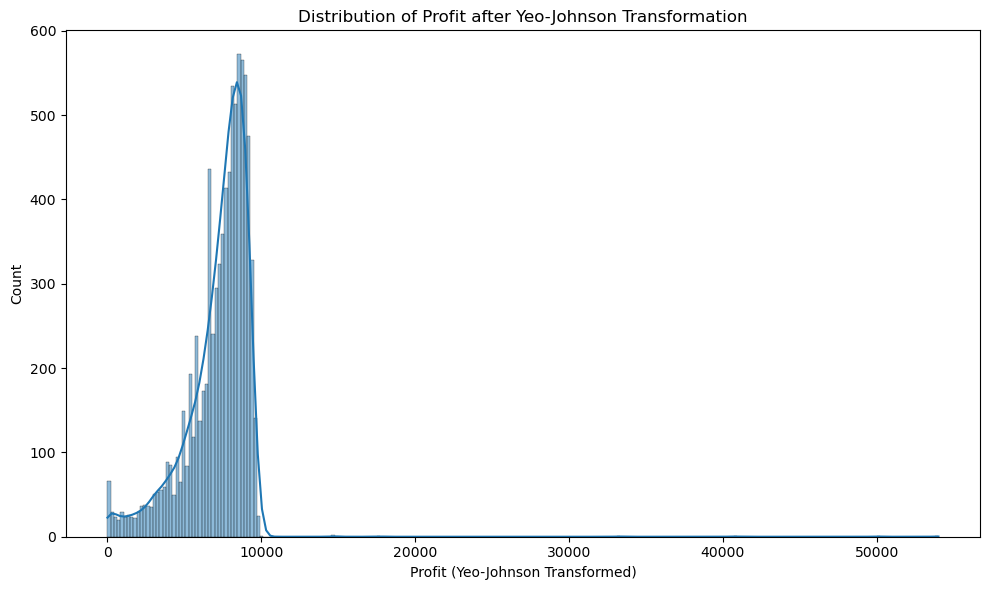

In [19]:
# Applying the Yeo-Johnson transformation to the 'Profit' feature
bigmart_data['Profit_yeojohnson_transformed'], lambda_value = yeojohnson(bigmart_data['Profit'])

# Visualizing the transformed data
plt.figure(figsize=(10, 6))
sns.histplot(bigmart_data['Profit_yeojohnson_transformed'], kde=True)
plt.title('Distribution of Profit after Yeo-Johnson Transformation')
plt.xlabel('Profit (Yeo-Johnson Transformed)')
plt.tight_layout()
plt.show()

The Quantile Transformer is a robust method that can map data to a uniform distribution (or a Gaussian distribution) by ranking the data. This can be particularly useful for dealing with features that have heavy tails or features that are on different scales.

The QuantileTransformer class in the sklearn.preprocessing module can be used for this transformation.

Here's the Python code to apply the Quantile Transformer to the Profit feature:

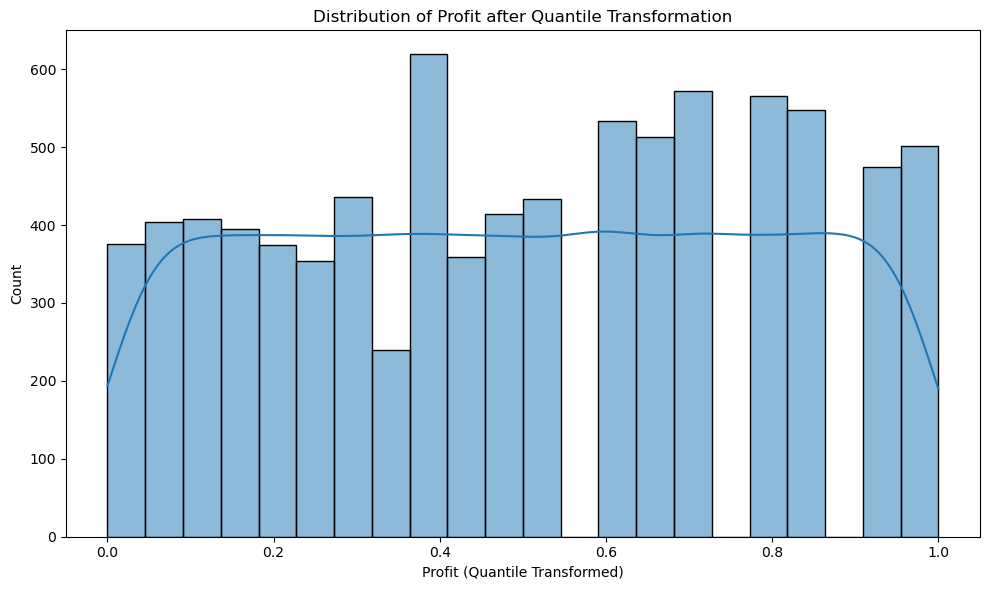

In [20]:
# Applying the Quantile Transformer to the 'Profit' feature
transformer = QuantileTransformer(output_distribution='uniform', random_state=0)
bigmart_data['Profit_quantile_transformed'] = transformer.fit_transform(bigmart_data[['Profit']])

# Visualizing the transformed data
plt.figure(figsize=(10, 6))
sns.histplot(bigmart_data['Profit_quantile_transformed'], kde=True)
plt.title('Distribution of Profit after Quantile Transformation')
plt.xlabel('Profit (Quantile Transformed)')
plt.tight_layout()
plt.show()

# Feature Encoding

Feature encoding is essential when dealing with categorical variables, especially for machine learning algorithms that expect numerical input values.

There are several methods for encoding categorical variables. Some of the most common ones include:

**One-Hot Encoding:** This method creates a binary column for each category in the original column. It's suitable for nominal data where no ordinal relationship exists.
    
**Label Encoding:** This method assigns a unique integer to each category. It's more suitable for ordinal data where an order between categories exists, but can be used for nominal data with tree-based algorithms.
    
**Ordinal Encoding:** Similar to label encoding but used explicitly for ordinal data where an order between categories exists.
    
**Frequency or Count Encoding:** Replace categories by the count of the occurrences or the frequency (proportion).

**Target Encoding (Mean Encoding):** Replace categories by the average target value for that category. Care must be taken to avoid data leakage.

For the Bigmart dataset, there are several categorical variables. We'll start by identifying them and then decide on the appropriate encoding technique for each. Let's first list out the categorical features in the dataset.

In [21]:
# Identifying categorical features in the dataset
categorical_features = bigmart_data.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


Let's examine each of the categorical features in the dataset and provide recommendations based on their nature:

**Item_Identifier:** This is an identification code for the product. As it likely has a large number of unique values, one-hot encoding might significantly increase the dimensionality of the dataset. A better approach might be to drop this feature unless it's essential for specific analyses or to use feature engineering to derive useful information from it.

**Item_Fat_Content:** This is nominal data representing the fat content of the item. One-hot encoding would be appropriate here. Additionally, this column might have inconsistent labeling (e.g., "Low Fat", "LF" both indicating low fat), so it would be good to standardize the labels first.

**Item_Type:** This is the type or category of the item, which is nominal data. One-hot encoding is recommended.

**Outlet_Identifier:** Like Item_Identifier, this is an identification code for the outlet. If there's a business reason to retain this feature, one-hot encoding might be used. Alternatively, it can be dropped or used to derive other features.

**Outlet_Establishment_Year:** This feature is ordinal since there's a clear order (older or newer year). While it's already in a numeric format, it might be more useful to convert this to the age of the outlet (e.g., "2023 - Outlet_Establishment_Year") to give a clearer picture of how old each outlet is.

**Outlet_Size:** This represents the size of the outlet and is ordinal data (e.g., Small < Medium < Large). Ordinal encoding can be used here.

**Outlet_Location_Type:** This is ordinal data representing the type of city in which the store is located. Ordinal encoding is suitable.

**Outlet_Type:** This is the type of outlet, which is nominal data. One-hot encoding is recommended.

Recommendations:

**Item_Identifier:** Drop or feature engineering.

**Item_Fat_Content:** One-hot encoding (after standardizing labels).

**Item_Type:** One-hot encoding.

**Outlet_Identifier:** Drop or one-hot encoding.

**Outlet_Establishment_Year:** Convert to outlet age.

**Outlet_Size:** Ordinal encoding.

**Outlet_Location_Type:** Ordinal encoding.

**Outlet_Type:** One-hot encoding.

In [22]:
# Dropping 'Item_Identifier' and 'Outlet_Identifier'
bigmart_data.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)

# Standardizing labels in 'Item_Fat_Content'
fat_content_mapping = {
    'Low Fat': 'Low Fat', 
    'Regular': 'Regular', 
    'LF': 'Low Fat', 
    'reg': 'Regular', 
    'low fat': 'Low Fat'
}
bigmart_data['Item_Fat_Content'] = bigmart_data['Item_Fat_Content'].map(fat_content_mapping)

# One-hot encoding for 'Item_Fat_Content', 'Item_Type', and 'Outlet_Type'
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)
one_hot_encoded_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Type']
one_hot_encoded_data = one_hot_encoder.fit_transform(bigmart_data[one_hot_encoded_columns])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=one_hot_encoder.get_feature_names_out(one_hot_encoded_columns))
bigmart_data = pd.concat([bigmart_data, one_hot_encoded_df], axis=1)
bigmart_data.drop(one_hot_encoded_columns, axis=1, inplace=True)

# Convert 'Outlet_Establishment_Year' to outlet age
current_year = 2023
bigmart_data['Outlet_Age'] = current_year - bigmart_data['Outlet_Establishment_Year']
bigmart_data.drop('Outlet_Establishment_Year', axis=1, inplace=True)

# Ordinal encoding for 'Outlet_Size' and 'Outlet_Location_Type'
ordinal_encodings = {
    'Outlet_Size': {'Small': 1, 'Medium': 2, 'High': 3},
    'Outlet_Location_Type': {'Tier 3': 3, 'Tier 2': 2, 'Tier 1': 1}
}
bigmart_data.replace(ordinal_encodings, inplace=True)

bigmart_data.head()

/Users/diogoribeiro/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Profit,Profit_log_transformed,Profit_inverse_transformed,Profit_sqrt_transformed,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Age
0,9.30,-2.283966,249.8,2,2,47.007885,11.61,2.451867,0.086133,3.407345,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24
1,5.92,-2.241226,48.3,2,2,20.958294,14.41,2.667922,0.069396,3.796051,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,14
2,17.50,-2.274222,141.6,2,2,37.964893,14.61,2.681706,0.068446,3.822303,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24
3,19.20,-2.585848,182.1,2,2,25.485930,13.71,2.618125,0.072939,3.702702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25
4,8.93,-2.585848,53.9,3,3,28.660858,14.21,2.653946,0.070373,3.769615,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36


# Feature Scaling

Feature scaling ensures that all features contribute equally to the computation of distances. There are two common methods:

**Standardization (Z-score normalization):** This method scales the features such that they have the properties of a standard normal distribution with a mean of 0 and a standard deviation of 1.

Formula:

$$
\begin{equation}
z = \frac{x - \mu}{\sigma}
\end{equation}
$$
 
Where:
x = original feature value
μ = mean of the feature
σ = standard deviation of the feature

**Min-Max Scaling:** This method scales and translates each feature individually such that it is in the given range on the training set, typically between zero and one.

Formula:
$$
\begin{equation}
x_{\text{scaled}} = \frac{x - \min(X)}{\max(X) - \min(X)}
\end{equation}
$$
 
Most machine learning algorithms perform better when numerical input variables are scaled to a standard range.

Let's proceed with Min-Max Scaling.

Min-Max Scaling scales features to lie between a given minimum and maximum value, often between 0 and 1. This transformation preserves the shape of the original distribution and doesn't change the information embedded in the original data.

Here's the Python code to apply Min-Max Scaling to the numerical features of the dataset:

In [23]:
# Identifying numerical columns
numerical_features = bigmart_data.select_dtypes(include=[float, int]).columns

# Applying Min-Max Scaling
scaler = MinMaxScaler()
bigmart_data[numerical_features] = scaler.fit_transform(bigmart_data[numerical_features])

bigmart_data.head()


NameError: name 'MinMaxScaler' is not defined